<a href="https://www.kaggle.com/code/artemsilvander/face-recognition-emotions-tuning-template?scriptVersionId=119594866" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# data management
import pandas as pd

# read and show images
from cv2 import cv2
import matplotlib.pyplot as plt  # plot

# file management
import os
from os.path import join

# Dataset

AffectNet is a large database of faces labeled by "affects" (psychological term for facial expressions). 
In order to accommodate common memory constraints, the resolution was reduced down to 96x96. 
Meaning that all images are exactly 96x96 pixels.

In [2]:
# let's see what is in labels file

path = ('/kaggle/input/affectnet-training-data/')
file = (path + 'labels.csv')
df = pd.read_csv(file)
df.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


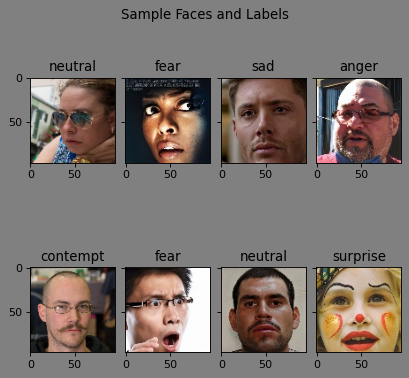

In [3]:
# display random images

import random

fig, axs = plt.subplots(2, 4, sharey=True, constrained_layout=True, num=None, 
                        figsize=(5, 5), dpi=80, facecolor='gray', edgecolor='k')
fig.suptitle("Sample Faces and Labels")
axs = axs.flatten()

for i in range(8):
    idx = random.randint(0, len(df)-1)  # randomly select an index
    img_path = path + df['pth'][idx]
    img = cv2.imread(img_path)  # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to BGR to RGB
    axs[i].imshow(img)
    axs[i].set_title(df['label'][idx])


In [4]:
# how many emotions categories

import os

INPUT_PATH = "/kaggle/input/affectnet-training-data/"
EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]
IMAGE_SIZE = (96, 96)

print(EMOTIONS)

['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']


In [5]:
# pre-process the data for CNN

# import cv2
# import numpy as np
# from keras.utils import to_categorical

# X = []
# y = []

# # walk over the folders, save the images in X and y lists and convert them into arrays

# for index, emotion in enumerate(EMOTIONS):
#     for filename in os.listdir(os.path.join(INPUT_PATH, emotion)):
#         img = cv2.imread(os.path.join(INPUT_PATH, emotion, filename))
#         img = cv2.resize(img, (96, 96))
#         #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to BGR to RGB
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to BGR to GREYscale        
#         X.append(img)
#         y.append(index)

# X = np.array(X).astype('float32') / 255.0 # normalize the X array 
# y = to_categorical(np.array(y)) # make categorical y

# Pre-process

In [6]:
# define functions to pre-process and load images into arrays

import cv2
import numpy as np
from keras.utils import to_categorical
import os

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            #img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y))
    return X, y

In [7]:
# Load the images
X, y = load_images(INPUT_PATH, EMOTIONS, IMAGE_SIZE)

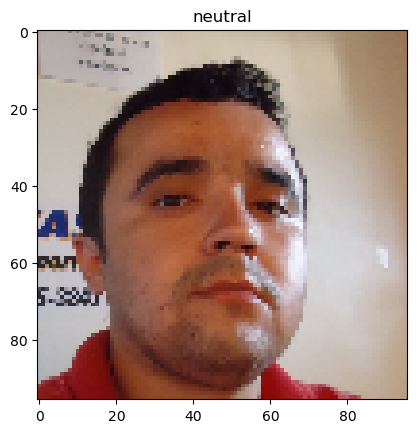

In [8]:
import matplotlib.pyplot as plt

# choose a random image index
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])
plt.title(EMOTIONS[np.argmax(y[idx])])
plt.show()


In [9]:
# Train test split pre-processed data

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# # create a stratified train-test split
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
# for train_index, test_index in split.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

input_shape = X_train[0].shape
#input_shape = (96,96,1) 

# Base model

In [10]:
# Let's try simple caegorical CNN model first

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3,3), activation="relu", input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer = Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45, 64)       2

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# datagen = ImageDataGenerator(
#     rotation_range=20, 
#     zoom_range=0.1, 
#     width_shift_range=0.1, 
#     height_shift_range=0.1, 
#     horizontal_flip=True)

# history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
#                     steps_per_epoch=len(X_train)//64,
#                     epochs=30,
#                     validation_data=(X_test, y_test),
#                     callbacks=[EarlyStopping(monitor='val_loss', patience=10),
#                                ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
#                                                  patience=3, min_lr=0.0001)],
#                     verbose=1)


history = model.fit(X_train, y_train, batch_size=128,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, 
                                                 patience=3, min_lr=0.0001)],
                    verbose=1)



Epoch 1/30
182/182 [==============================] - 13s 36ms/step - loss: 7.1499 - accuracy: 0.3035 - val_loss: 6.0890 - val_accuracy: 0.4209 - lr: 1.0000e-04
Epoch 2/30
182/182 [==============================] - 6s 33ms/step - loss: 6.1949 - accuracy: 0.3958 - val_loss: 5.4876 - val_accuracy: 0.4798 - lr: 1.0000e-04
Epoch 3/30
182/182 [==============================] - 6s 32ms/step - loss: 5.5262 - accuracy: 0.4449 - val_loss: 4.9882 - val_accuracy: 0.5006 - lr: 1.0000e-04
Epoch 4/30
182/182 [==============================] - 6s 32ms/step - loss: 4.9450 - accuracy: 0.4787 - val_loss: 4.5128 - val_accuracy: 0.5211 - lr: 1.0000e-04
Epoch 5/30
182/182 [==============================] - 6s 32ms/step - loss: 4.4271 - accuracy: 0.5061 - val_loss: 4.0668 - val_accuracy: 0.5326 - lr: 1.0000e-04
Epoch 6/30
182/182 [==============================] - 6s 32ms/step - loss: 3.9754 - accuracy: 0.5224 - val_loss: 3.6822 - val_accuracy: 0.5404 - lr: 1.0000e-04
Epoch 7/30
182/182 [===================

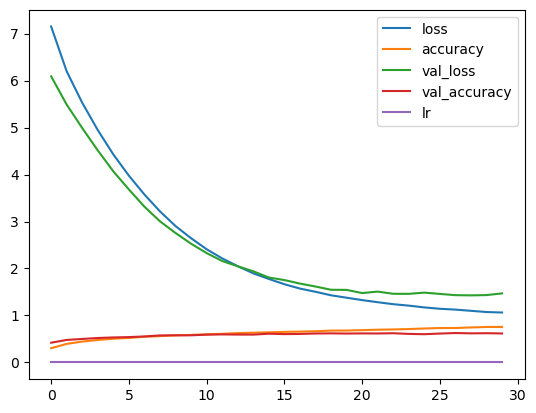

In [12]:
pd.DataFrame(history.history).plot();

In [13]:
from sklearn.metrics import r2_score

# Make predictions
y_pred = model.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score:", r2)

182/182 [==============================] - 1s 3ms/step
R2 score: 0.3814444660422994


In [14]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))


182/182 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.49      0.63      0.55       815
           1       0.60      0.29      0.39       660
           2       0.82      0.87      0.84       982
           3       0.45      0.42      0.43       582
           4       0.42      0.45      0.43       517
           5       0.50      0.70      0.58       578
           6       0.89      0.90      0.89       988
           7       0.55      0.38      0.45       687

    accuracy                           0.62      5809
   macro avg       0.59      0.58      0.57      5809
weighted avg       0.62      0.62      0.61      5809



# Functions for Tuning